## 목차
### 1. kaggle 구현된 내용 파악
* https://www.kaggle.com/allunia/how-to-attack-a-machine-learning-model/notebook?select=train.csv


### 2. Fast Gradient Sign Method 추가 구현
* Mnist data
* CIFAR10 data


### 3. 앞으로 할 일
* https://christophm.github.io/interpretable-ml-book/adversarial.html 에 소개된 내용에 적용해보기
* 다른 Classification Algorithm에 적용해보기 ex. LDA, Neural Network

### -------------------------------------------------------------

## 1. Kaggle 구현된 내용 파악

* [Loading data and packages](#load)
* [Attack methods and class](#methods)
* [Training the model](#training)
* [Non-Targeted-Attack](#nontargeted): 
    * Maximizing the output-target discrepance
    * Natural fooling targets 
* [Targeted-Attack](#targeted): 
    * One image example
    * Natural vs non-natural fooling targets & accuracy score breakdown for all images (Reworked)
* [Comparison to Fast Gradient Method](#fastgradient): 
    * Thoughts: Maximizing discrepance vs. minimizing likelihood
* [The Jacobian enters the door](#jacobian)
* [Conclusion](#conclusion)

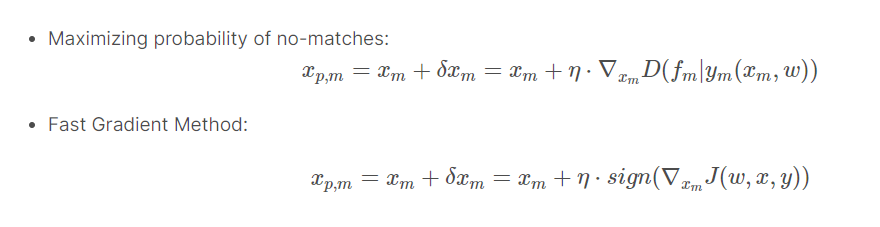

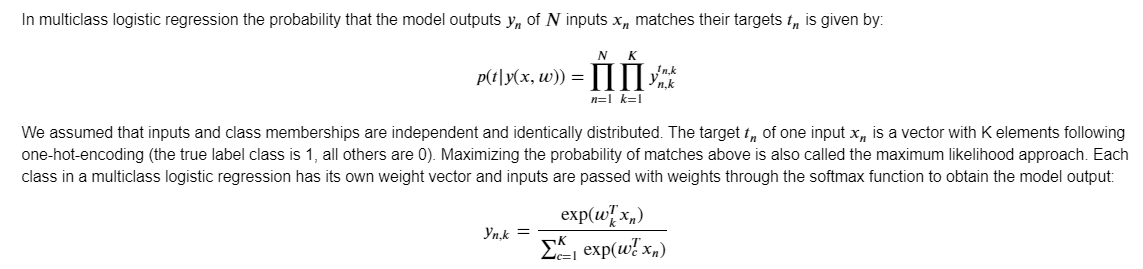

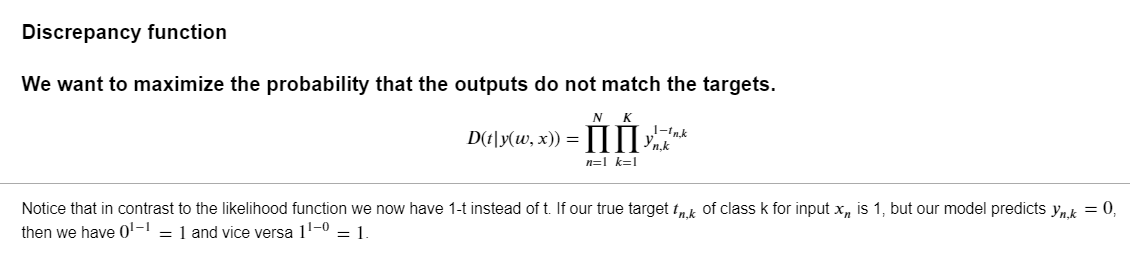

## Loading packages <a class="anchor" id="load"></a>


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn import datasets as dt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import pandas as pd
import numpy as np
import seaborn as sns


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from skimage.io import imread, imshow

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Loading data 


In [5]:
df = pd.read_csv("Digit Recognizer/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y = df.label.values
X = df.drop("label",axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

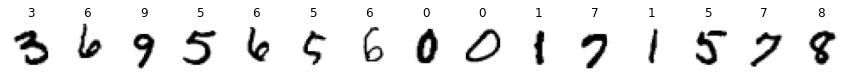

In [7]:
fig1, ax1 = plt.subplots(1,15, figsize=(15,10))
for i in range(15):
    ax1[i].imshow(X_test[i].reshape((28,28)), cmap="gray_r")
    ax1[i].axis('off')
    ax1[i].set_title(y_test[i])

### Attack class

In [8]:
class Attack:

    def __init__(self, model):
        self.fooling_targets = None
        self.model = model
    
    def prepare(self, X_train, y_train, X_test, y_test):
        self.images = X_test
        self.true_targets = y_test
        self.num_samples = X_test.shape[0]
        self.train(X_train, y_train)
        print("Model training finished.")
        self.test(X_test, y_test)
        print("Model testing finished. Initial accuracy score: " + str(self.initial_score))
    
    def set_fooling_targets(self, fooling_targets):
        self.fooling_targets = fooling_targets
    
    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        self.weights = self.model.coef_
        self.num_classes = self.weights.shape[0]

    def test(self, X_test, y_test):
        self.preds = self.model.predict(X_test)
        self.preds_proba = self.model.predict_proba(X_test)
        self.initial_score = accuracy_score(y_test, self.preds)
    
    def create_one_hot_targets(self, targets):
        self.one_hot_targets = np.zeros(self.preds_proba.shape)
        for n in range(targets.shape[0]):
            self.one_hot_targets[n, targets[n]] = 1
            
    def attack(self, attackmethod, epsilon):
        perturbed_images, highest_epsilon = self.perturb_images(epsilon, attackmethod)
        perturbed_preds = self.model.predict(perturbed_images)
        score = accuracy_score(self.true_targets, perturbed_preds)
        return perturbed_images, perturbed_preds, score, highest_epsilon
    
    def perturb_images(self, epsilon, gradient_method):
        perturbed = np.zeros(self.images.shape)
        max_perturbations = []
        for n in range(self.images.shape[0]):
            perturbation = self.get_perturbation(epsilon, gradient_method, self.one_hot_targets[n], self.preds_proba[n])
            perturbed[n] = self.images[n] + perturbation
            max_perturbations.append(np.max(perturbation))
        highest_epsilon = np.max(np.array(max_perturbations))
        return perturbed, highest_epsilon
    
    def get_perturbation(self, epsilon, gradient_method, target, pred_proba):
        if gradient_method == 'FGSM1':
            dlt = pred_proba - target
            gradient = np.matmul(dlt, self.weights)
            gradient = np.sign(gradient)
        else:
            gradient = gradient_method(target, pred_proba, self.weights)
        inf_norm = np.max(gradient)
        perturbation = epsilon/inf_norm * gradient
        return perturbation
    
    def attack_to_max_epsilon(self, attackmethod, max_epsilon):
        self.max_epsilon = max_epsilon
        self.scores = []
        self.epsilons = []
        self.perturbed_images_per_epsilon = []
        self.perturbed_outputs_per_epsilon = []
        for epsilon in range(0, self.max_epsilon):
            perturbed_images, perturbed_preds, score, highest_epsilon = self.attack(attackmethod, epsilon)
            self.epsilons.append(highest_epsilon)
            self.scores.append(score)
            self.perturbed_images_per_epsilon.append(perturbed_images)
            self.perturbed_outputs_per_epsilon.append(perturbed_preds)

### Attack methods 

In [9]:
def calc_output_weighted_weights(output, w):
    for c in range(len(output)):
        if c == 0:
            weighted_weights = output[c] * w[c]
        else:
            weighted_weights += output[c] * w[c]
    return weighted_weights

def targeted_gradient(foolingtarget, output, w):
    ww = calc_output_weighted_weights(output, w)
    for k in range(len(output)):
        if k == 0:
            gradient = foolingtarget[k] * (w[k]-ww)
        else:
            gradient += foolingtarget[k] * (w[k]-ww)
    return gradient

def non_targeted_gradient(target, output, w):
    ww = calc_output_weighted_weights(output, w)
    for k in range(len(target)):
        if k == 0:
            gradient = (1-target[k]) * (w[k]-ww)
        else:
            gradient += (1-target[k]) * (w[k]-ww)
    return gradient

def FGSM2(target, output, w):
    ww = calc_output_weighted_weights(output, w)
    for k in range(len(target)):
        if k == 0:
            gradient = (-target[k]) * (w[k]-ww)
        else:
            gradient += (-target[k]) * (w[k]-ww)
    return gradient
    
    
def non_targeted_sign_gradient(target, output, w):
    gradient = non_targeted_gradient(target, output, w)
    return np.sign(gradient)

## Training the model <a class="anchor" id="training"></a>

In [10]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', fit_intercept=False)

In [11]:
attack = Attack(model)
attack.prepare(X_train, y_train, X_test, y_test)

Model training finished.
Model testing finished. Initial accuracy score: 0.909345238095238


In [12]:
weights = attack.weights
weights.shape

(10, 784)

## Non-targeted Attack: Maximizing output-target discrepance <a class="anchor" id="nontargeted"></a>

### Discrepancy function
### We want to maximize the probability that the outputs do not match the targets.
$$ D(t|y(w,x)) = \prod_{n=1}^{N} \prod_{k=1}^{K} y_{n,k}^{1-t_{n,k}} $$

Notice that in contrast to the likelihood function we now have 1-t instead of t. If our true target $t_{n,k}$ of class k for input $x_{n}$ is 1, but our model predicts $y_{n,k}=0$, then we have $0^{1-1}=1$ and vice versa $1^{1-0}=1$.  

To train a model we usually would maximize the likelihood with respect to the weight parameters whereas inputs are fixed. In our case we already have a trained model and fixed weights. But we can add tiny perturbations to our input images such that we maximize our discrepancy function. Let's do that and for making things simpler we use the log! :-)

$$\nabla_{x} \hat{D} = \nabla_{x} log D = \nabla_{x} \sum_{n=1}^{N} \sum_{k=1}^{K} (1-t_{k}) \log y_{k} $$

$$\hat{D} = \sum_{n=1}^{N} \sum_{k=1}^{K} (1-t_{n,k}) \log y_{n,k}$$

$$ \partial_{x} \hat{D} = \sum_{n=1}^{N} \sum_{k=1}^{K} \frac {\partial \hat{D}}{\partial y_{k}} \frac {\partial y_{k}}{\partial x} $$

The first part is easy:

$$ \frac {\partial \hat{D}}{\partial y_{k}}  = \frac {1-t_{k}} {y_{k}}$$

For the second part we should keep in mind the gradient of activations yields the class weight vector:

$$ a_{c} = \vec{w_{c}}^{T} \vec{x} = \vec{x}^{T} \vec{w_{c}} $$

$$ \nabla_{x} a_{c} = \vec{w_{c}} $$

$$ y_{k} = \frac{\exp(a_{k})} {\sum_{c=1}^{K}\exp(a_{c})}$$

Now this second part is a bit cumbersome (... hopefully I didn't make a mistake ...):

$$ \frac {\partial y_{k}}{\partial x} = \frac{\Sigma \cdot \partial_{x} \exp(a_{k}) - \exp(a_{k}) \partial_{x} \Sigma}{\Sigma^{2}} = \frac {\sum_{c=1}^{K} \exp(a_{c}) \cdot \vec{w}_{k} \exp(a_{k}) - \exp(a_{k}) \sum_{c=1}^{K} \vec{w}_{c} \exp(a_{c})} {\sum_{c=1}^{K}\exp(a_{c}) \cdot \sum_{c=1}^{K}\exp(a_{c})} $$

$$ \frac {\partial y_{k}}{\partial x} =  y_{k} \vec{w}_{k} - y_{k} \cdot \sum_{c=1}^{K} y_{c} \vec{w}_{c}  $$

Finally I end up with:

$$ \nabla_{x} \log D = \sum_{k=1}^{K} (1-t_{k}) \cdot  (\vec{w}_{k} - \sum_{c=1}^{K} y_{c} \vec{w}_{c}) $$

Let's try to understand this: For the true label the summand is 0 whereas all other classes contribute to the gradient with their class weight vector $\vec{w_{k}}$ reduced by an output "weighted" sum of all other class weights. What does that mean? ...

To maximize the discrepance for playing around we can use gradient ascent. Though we have to find a sufficient rate $\eta$. Given an input $x_{m}$ we will then add a perturbation with:

$$ x_{p, m} = x_{m} + \delta x_{m} = x_{m} + \eta \cdot \nabla_{x_{m,c}} D_{m,c} $$

$$ x_{p, m} = x_{m} + \eta \sum_{k=1}^{K} (1-t_{m,k}) \cdot  (\vec{w}_{k} - \sum_{c=1}^{K} y_{m,c} \vec{w}_{c}) $$

### Adding tiny perturbations

# 📍[Case1]: Non-targeted Gradient Attack

In [13]:
attack.create_one_hot_targets(y_test)
attack.attack_to_max_epsilon(non_targeted_gradient, 30)
non_targeted_scores = attack.scores

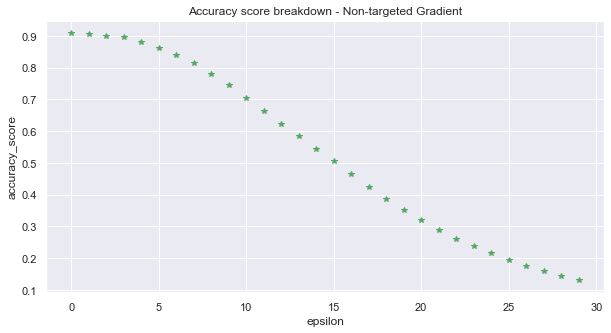

In [14]:
sns.set()
plt.figure(figsize=(10,5))
plt.plot(attack.epsilons, attack.scores, 'g*')
plt.ylabel('accuracy_score')
plt.xlabel('epsilon')
plt.title('Accuracy score breakdown - Non-targeted Gradient');

Uii, the threshold is given by a max of 16 pixel that are allowed to be added as perturbation per pixel per image. Given this $\epsilon$ we would end up with a model that still predicts around 40 % correctly. If we would use max $\epsilon=30$ the model would fail with almoast 90 % digits in the test set :-) . Let's have a look at one example of successful fooling for a range of epsilons until max of $\epsilon = 16$.

In [15]:
eps = 16
attack.epsilons[eps]

16.0

We need the perturbed images as well as the fooling results of that epsilon:

In [16]:
example_images = attack.perturbed_images_per_epsilon[eps]
example_preds = attack.perturbed_outputs_per_epsilon[eps]

And I will store results in a pandas dataframe such that we can easily find successful foolings:

In [17]:
example_results = pd.DataFrame(data=attack.true_targets, columns=['y_true'])
example_results['y_fooled'] = example_preds
example_results['y_predicted'] = attack.preds
example_results['id'] = example_results.index.values
print(example_results.shape)
example_results.head()

(16800, 4)


,y_true,y_fooled,y_predicted,id
0,3,8,3,0
1,6,6,6,1
2,9,9,9,2
3,5,8,5,3
4,6,6,6,4


In [18]:
success_df = example_results[example_results.y_fooled != example_results.y_true]
success_df.head()

,y_true,y_fooled,y_predicted,id
0,3,8,3,0
3,5,8,5,3
5,5,9,0,5
6,6,2,6,6
14,8,5,8,14


## image 시각화하여 확인해보기 

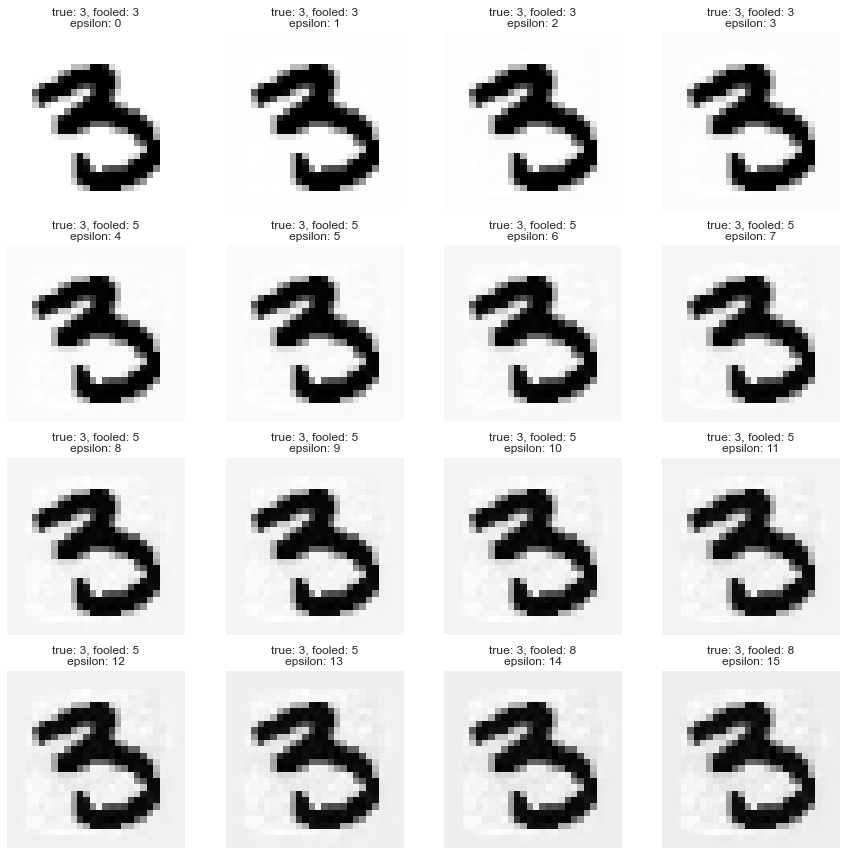

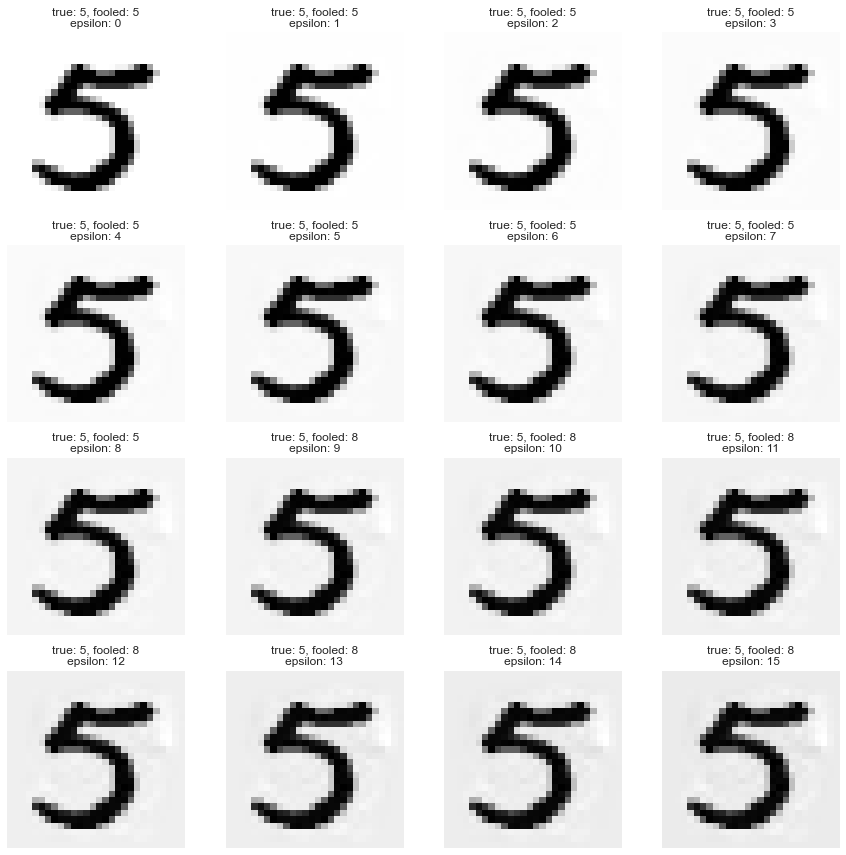

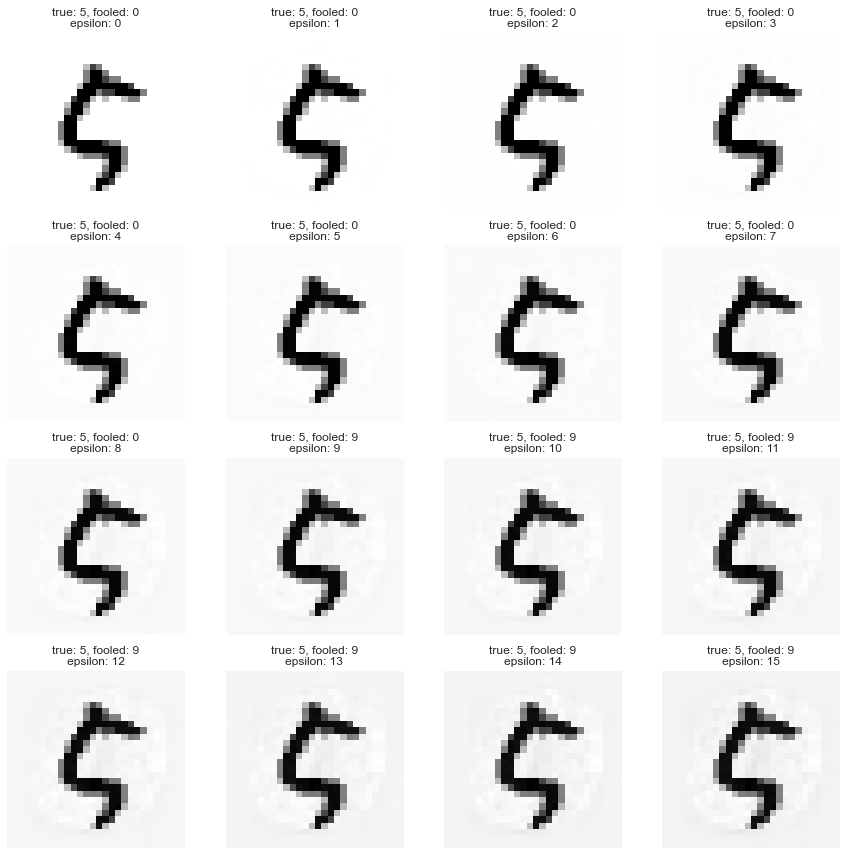

In [19]:
for i in range(3):
    example_id = success_df.id.values[i]

    fig2, ax2 = plt.subplots(4,4, figsize=(15,15))
    for i in range(4):
        for j in range(4):
            image = attack.perturbed_images_per_epsilon[i*4 + j][example_id]
            y_fooled = attack.perturbed_outputs_per_epsilon[i*4 + j][example_id]
            epsilon = attack.epsilons[i*4 +j]
            ax2[i,j].imshow(image.reshape((28,28)), cmap="gray_r")
            ax2[i,j].axis('off')
            ax2[i,j].set_title("true: " + str(y_test[example_id]) + ", fooled: " + str(y_fooled)  + "\n" 
                               + "epsilon: " + str(np.int(epsilon)))

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.00269126 -0.00589293  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.00127769 -0.0027977   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.00148777 -0.00325769  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


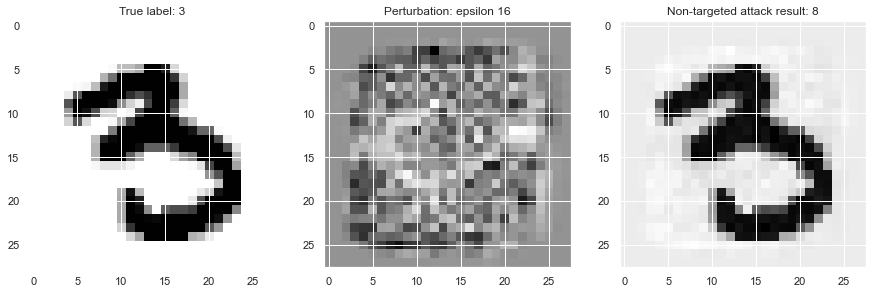

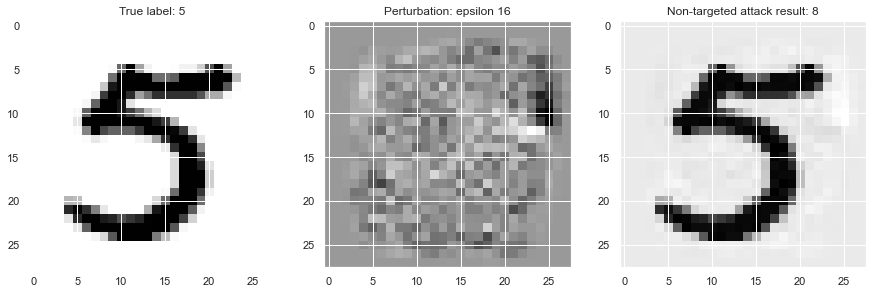

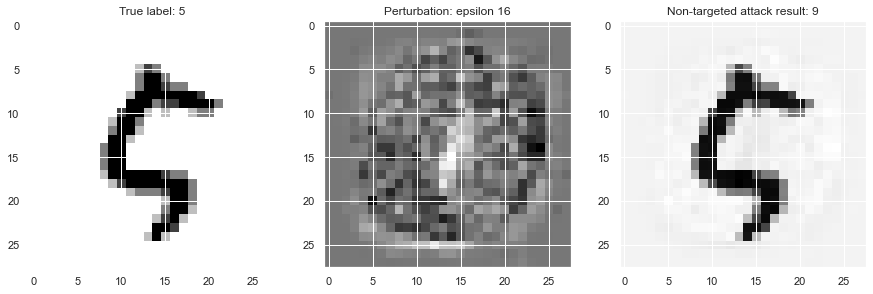

In [31]:
for i in range(3):
    example_id = success_df.id.values[i]

    fig, (axA, axC, axB) = plt.subplots(1, 3, figsize=(15,5))
    
    axA.imshow(X_test[example_id].reshape((28,28)),cmap = 'gray_r')
    axA.set_title("True label: " + str(y_test[example_id]))
    
    axB.imshow(example_images[example_id].reshape((28,28)),cmap = 'gray_r')
    axB.set_title("Non-targeted attack result: " + str(example_preds[example_id]))
    
    axC.imshow((X_test[example_id]-example_images[example_id]).reshape((28,28)),cmap = 'gray_r')
    print((X_test[example_id]-example_images[example_id]).reshape((28,28))[0])
    axC.set_title("Perturbation: epsilon 16");

### [The gradient travel guide - natural fooling targets]

### I think, that there are preffered numbers to be wrong predictions given a digit input image. Perhaps the fooling gradients drives us to those "natural" fooling target numbers? 

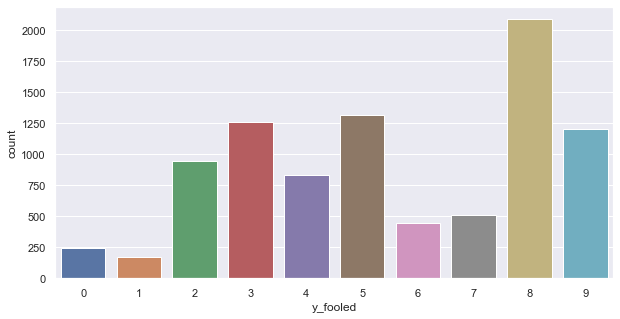

In [89]:
plt.figure(figsize=(10,5))
sns.countplot(x='y_fooled', data=example_results[example_results.y_true != example_results.y_fooled])

In [90]:
wrong_predictions = example_results[example_results.y_true != example_results.y_predicted]
wrong_predictions.shape

(1523, 4)

In [91]:
X_test.shape

(16800, 784)

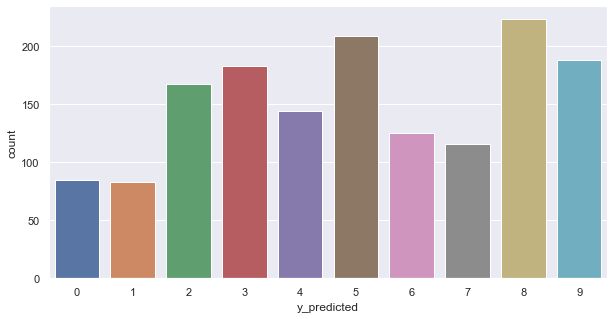

In [92]:
plt.figure(figsize=(10,5))
sns.countplot(x='y_predicted', data=wrong_predictions)

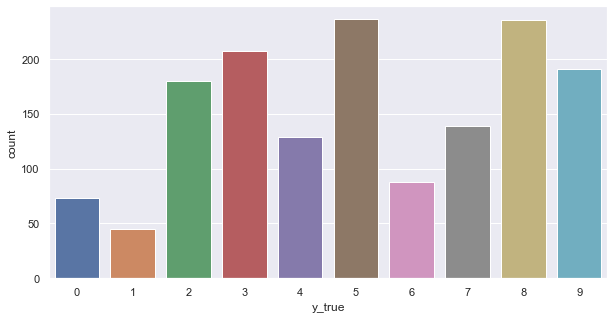

In [93]:
plt.figure(figsize=(10,5))
sns.countplot(x='y_true', data=wrong_predictions)

### Which are the natural fooling targets (for successful foolings) for each digit?

In [94]:
attacktargets = example_results.loc[example_results.y_true != example_results.y_fooled].groupby(
    'y_true').y_fooled.value_counts()
counts = example_results.loc[example_results.y_true != example_results.y_fooled].groupby(
    'y_true').y_fooled.count()
attacktargets = attacktargets/counts * 100
attacktargets = attacktargets.unstack()
attacktargets = attacktargets.fillna(0.0) 
attacktargets = attacktargets.apply(np.round).astype(np.int)

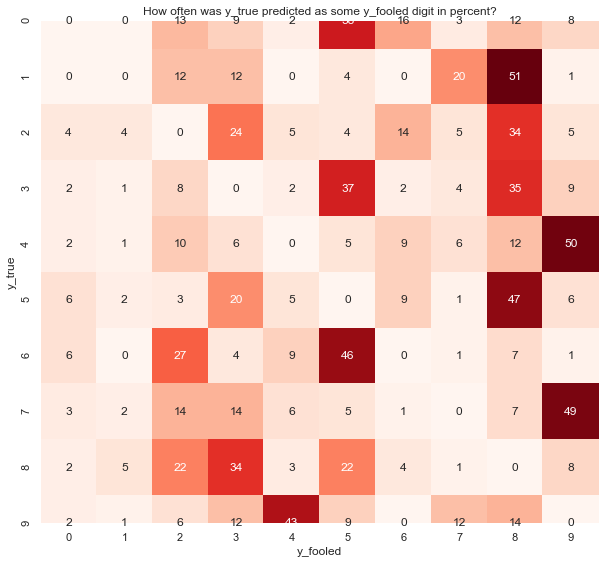

In [95]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(attacktargets, annot=True, ax=ax, cbar=False, square=True, cmap="Reds", fmt="g");
ax.set_title("How often was y_true predicted as some y_fooled digit in percent?");

### We found out that each digit has its natural fooling target. 

For example 3 was likely predicted as 5 or 8 which makes sense as all three have "two bubbles" on top of each other as a sketch shape. You can see that 8 was a good fooling choice for several digits... interestingly for 1 as well. In addition we find that for some images both holds: 4 and 9 for example are possible in both ways.

## Comparison to "discrepance" Gradient Sign Method

Some small experiment: Let's only take the sign of the gradient of our attack. I think we will not be as goog as we could be with the full gradient:

In [ ]:
attack.create_one_hot_targets(y_test)
attack.attack_to_max_epsilon(non_targeted_sign_gradient, 30)

In [ ]:
plt.figure(figsize=(10,5))
gm, = plt.plot(attack.epsilons, non_targeted_scores, 'g*', label='gradient method')
gsm, = plt.plot(attack.epsilons, attack.scores, 'r*', label='gradient sign method')
plt.ylabel('accuracy_score')
plt.xlabel('eta')
plt.legend(handles=[gm, gsm])
plt.title('Accuracy score breakdown')

Uiih!! :-o That's a surprise. 

# 📍[Case2]: FGSM1 (Fast Gradient Sign Method1)

https://towardsdatascience.com/perhaps-the-simplest-introduction-of-adversarial-examples-ever-c0839a759b8d
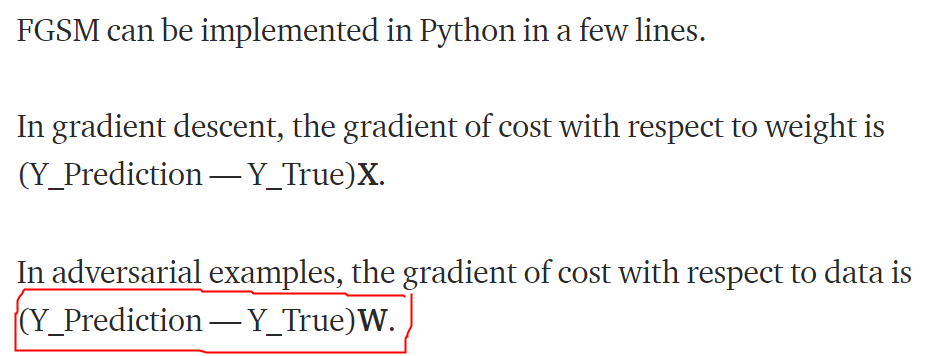

In [96]:
attack.create_one_hot_targets(y_test)
attack.attack_to_max_epsilon('FGSM1', 30)
non_targeted_scores = attack.scores

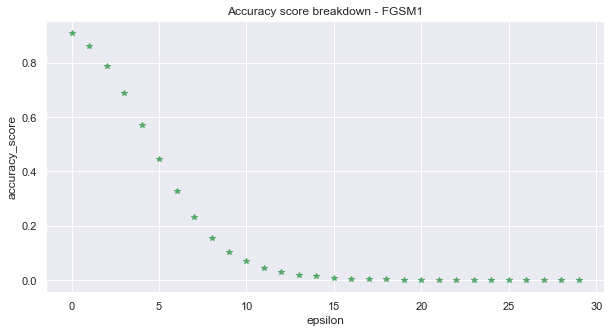

In [97]:
sns.set()
plt.figure(figsize=(10,5))
plt.plot(attack.epsilons, attack.scores, 'g*')
plt.ylabel('accuracy_score')
plt.xlabel('epsilon')
plt.title('Accuracy score breakdown - FGSM1');

In [98]:
example_images = attack.perturbed_images_per_epsilon[eps]
example_preds = attack.perturbed_outputs_per_epsilon[eps]

In [99]:
example_results = pd.DataFrame(data=attack.true_targets, columns=['y_true'])
example_results['y_fooled'] = example_preds
example_results['y_predicted'] = attack.preds
example_results['id'] = example_results.index.values
example_results.head()

,y_true,y_fooled,y_predicted,id
0,3,5,3,0
1,6,4,6,1
2,9,7,9,2
3,5,8,5,3
4,6,2,6,4


In [100]:
success_df = example_results[example_results.y_fooled != example_results.y_true]
success_df.head()

,y_true,y_fooled,y_predicted,id
0,3,5,3,0
1,6,4,6,1
2,9,7,9,2
3,5,8,5,3
4,6,2,6,4


Ok, we will choose one of these successful examples and plot its related perturbed image over a range of epsilons: 

In [101]:
example_id = success_df.id.values[0]
example_id

0

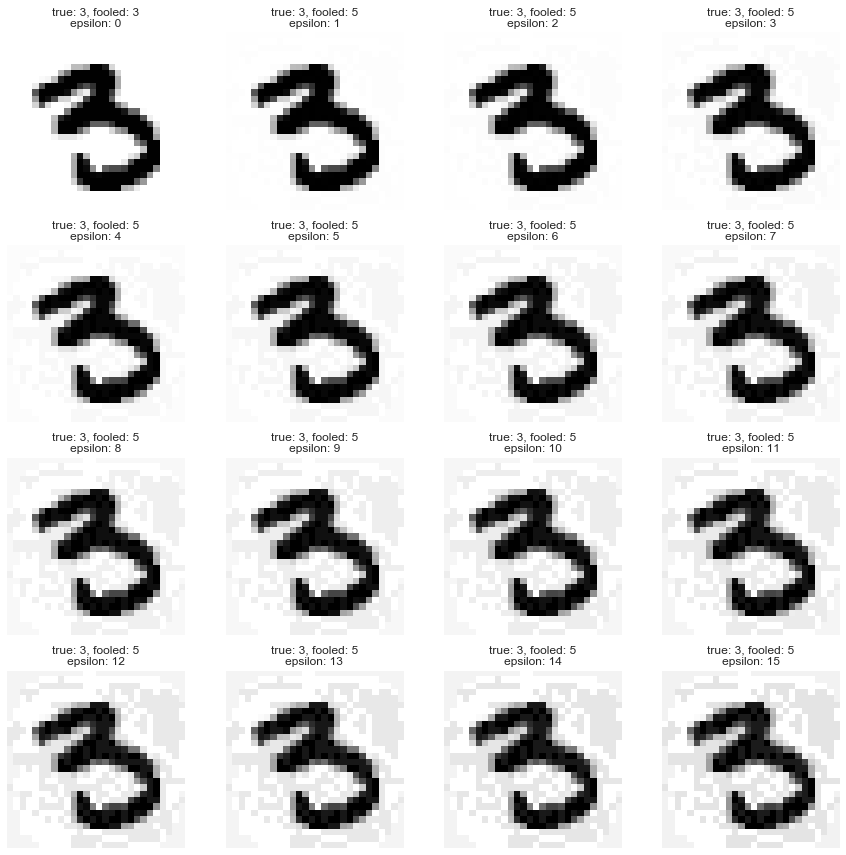

In [102]:
fig2, ax2 = plt.subplots(4,4, figsize=(15,15))
for i in range(4):
    for j in range(4):
        image = attack.perturbed_images_per_epsilon[i*4 + j][example_id]
        y_fooled = attack.perturbed_outputs_per_epsilon[i*4 + j][example_id]
        epsilon = attack.epsilons[i*4 +j]
        ax2[i,j].imshow(image.reshape((28,28)), cmap="gray_r")
        ax2[i,j].axis('off')
        ax2[i,j].set_title("true: " + str(y_test[example_id]) + ", fooled: " + str(y_fooled)  + "\n" 
                           + "epsilon: " + str(np.int(epsilon)))

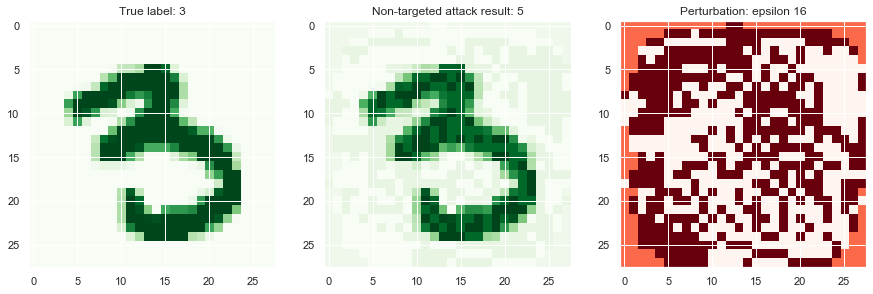

In [106]:
fig, (axA, axB, axC) = plt.subplots(1, 3, figsize=(15,5))
axB.imshow(example_images[example_id].reshape((28,28)), cmap='Greens')
axB.set_title("Non-targeted attack result: " + str(example_preds[example_id]))
axA.imshow(X_test[example_id].reshape((28,28)), cmap='Greens')
axA.set_title("True label: " + str(y_test[example_id]))
axC.imshow((X_test[example_id]-example_images[example_id]).reshape((28,28)), cmap='Reds')
axC.set_title("Perturbation: epsilon 16");

### The gradient travel guide - natural fooling targets

I'm happy that it was possible to fool our model but it's still diffuse and unclear where the one-step-gradient guides us through (remember we do not iterate with gradient ascent, we just take one step and size is given by strength of gradient times eta). I assume that some numbers are closer to each other in weight space than to others. As the model training draws decision boundaries dependent on the quality of the input data and flexibility of model architecture, there will be regions where a 3 is not predicted as 3 but as 8. Those regions where the model makes an incorrect prediction. And I think, that there are preffered numbers to be wrong predictions given a digit input image. Perhaps the fooling gradients drives us to those "natural" fooling target numbers? 

In [108]:
attacktargets = example_results.loc[example_results.y_true != example_results.y_fooled].groupby(
    'y_true').y_fooled.value_counts()
counts = example_results.loc[example_results.y_true != example_results.y_fooled].groupby(
    'y_true').y_fooled.count()
attacktargets = attacktargets/counts * 100
attacktargets = attacktargets.unstack()
attacktargets = attacktargets.fillna(0.0) 
attacktargets = attacktargets.apply(np.round).astype(np.int)

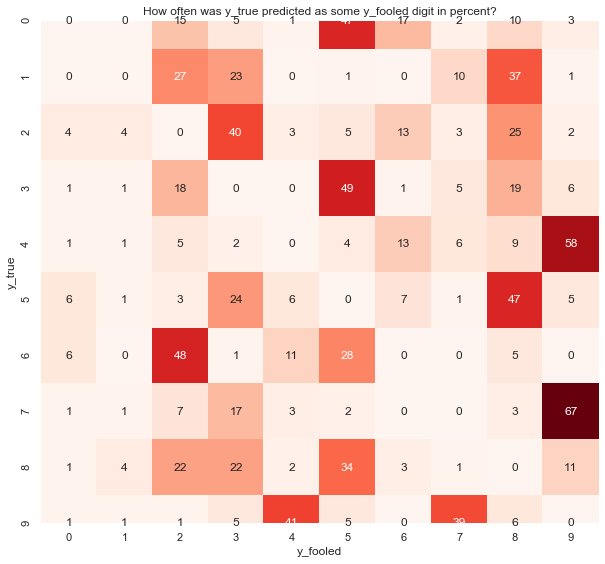

In [109]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(attacktargets, annot=True, ax=ax, cbar=False, square=True, cmap="Reds", fmt="g");
ax.set_title("How often was y_true predicted as some y_fooled digit in percent?");

# 📍[Result for FGSM2]

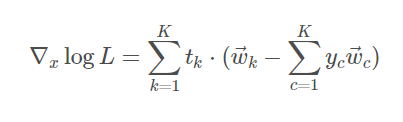

In [110]:
attack.create_one_hot_targets(y_test)
attack.attack_to_max_epsilon(FGSM2, 30)
non_targeted_scores = attack.scores

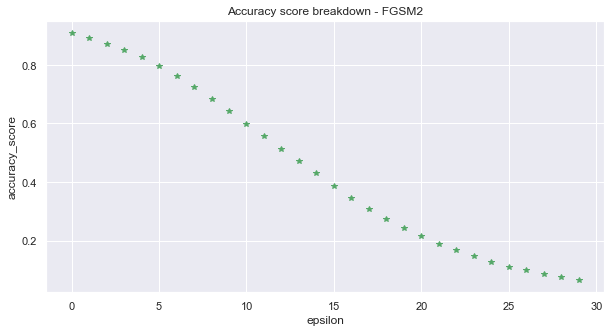

In [111]:
sns.set()
plt.figure(figsize=(10,5))
plt.plot(attack.epsilons, attack.scores, 'g*')
plt.ylabel('accuracy_score')
plt.xlabel('epsilon')
plt.title('Accuracy score breakdown - FGSM2');

In [112]:
example_images = attack.perturbed_images_per_epsilon[eps]
example_preds = attack.perturbed_outputs_per_epsilon[eps]

In [113]:
example_results = pd.DataFrame(data=attack.true_targets, columns=['y_true'])
example_results['y_fooled'] = example_preds
example_results['y_predicted'] = attack.preds
example_results['id'] = example_results.index.values
example_results.head()

,y_true,y_fooled,y_predicted,id
0,3,5,3,0
1,6,4,6,1
2,9,7,9,2
3,5,8,5,3
4,6,6,6,4


In [114]:
success_df = example_results[example_results.y_fooled != example_results.y_true]
success_df.head()

,y_true,y_fooled,y_predicted,id
0,3,5,3,0
1,6,4,6,1
2,9,7,9,2
3,5,8,5,3
5,5,0,0,5


In [115]:
example_id = success_df.id.values[0]
example_id

0

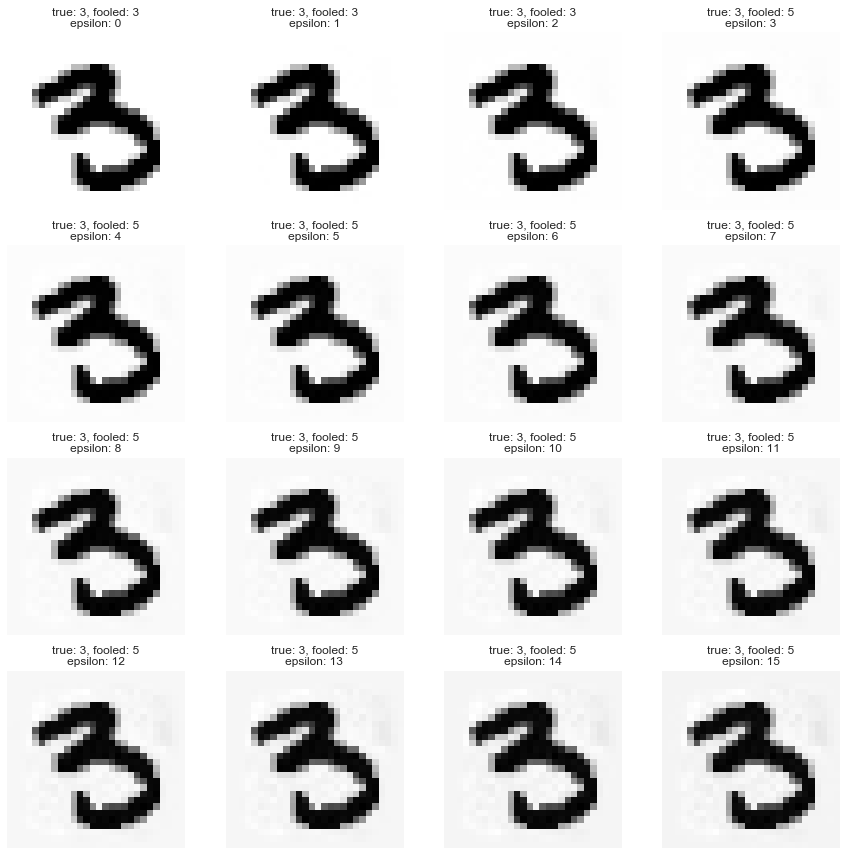

In [116]:
fig2, ax2 = plt.subplots(4,4, figsize=(15,15))
for i in range(4):
    for j in range(4):
        image = attack.perturbed_images_per_epsilon[i*4 + j][example_id]
        y_fooled = attack.perturbed_outputs_per_epsilon[i*4 + j][example_id]
        epsilon = attack.epsilons[i*4 +j]
        ax2[i,j].imshow(image.reshape((28,28)), cmap="gray_r")
        ax2[i,j].axis('off')
        ax2[i,j].set_title("true: " + str(y_test[example_id]) + ", fooled: " + str(y_fooled)  + "\n" 
                           + "epsilon: " + str(np.int(epsilon)))

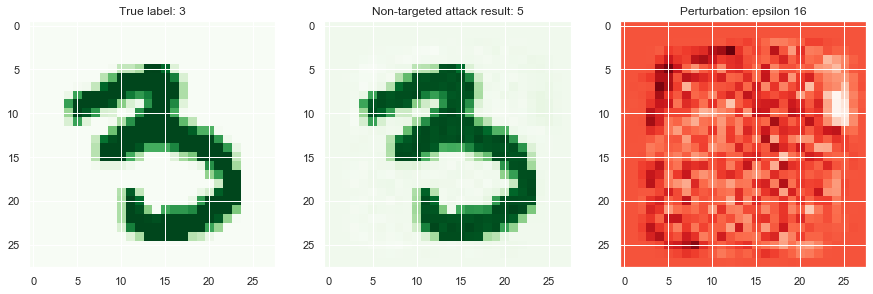

In [117]:
fig, (axA, axB, axC) = plt.subplots(1, 3, figsize=(15,5))
axB.imshow(example_images[example_id].reshape((28,28)), cmap='Greens')
axB.set_title("Non-targeted attack result: " + str(example_preds[example_id]))
axA.imshow(X_test[example_id].reshape((28,28)), cmap='Greens')
axA.set_title("True label: " + str(y_test[example_id]))
axC.imshow((X_test[example_id]-example_images[example_id]).reshape((28,28)), cmap='Reds')
axC.set_title("Perturbation: epsilon 16");

### The gradient travel guide - natural fooling targets

I'm happy that it was possible to fool our model but it's still diffuse and unclear where the one-step-gradient guides us through (remember we do not iterate with gradient ascent, we just take one step and size is given by strength of gradient times eta). I assume that some numbers are closer to each other in weight space than to others. As the model training draws decision boundaries dependent on the quality of the input data and flexibility of model architecture, there will be regions where a 3 is not predicted as 3 but as 8. Those regions where the model makes an incorrect prediction. And I think, that there are preffered numbers to be wrong predictions given a digit input image. Perhaps the fooling gradients drives us to those "natural" fooling target numbers? 

In [118]:
attacktargets = example_results.loc[example_results.y_true != example_results.y_fooled].groupby(
    'y_true').y_fooled.value_counts()
counts = example_results.loc[example_results.y_true != example_results.y_fooled].groupby(
    'y_true').y_fooled.count()
attacktargets = attacktargets/counts * 100
attacktargets = attacktargets.unstack()
attacktargets = attacktargets.fillna(0.0) 
attacktargets = attacktargets.apply(np.round).astype(np.int)

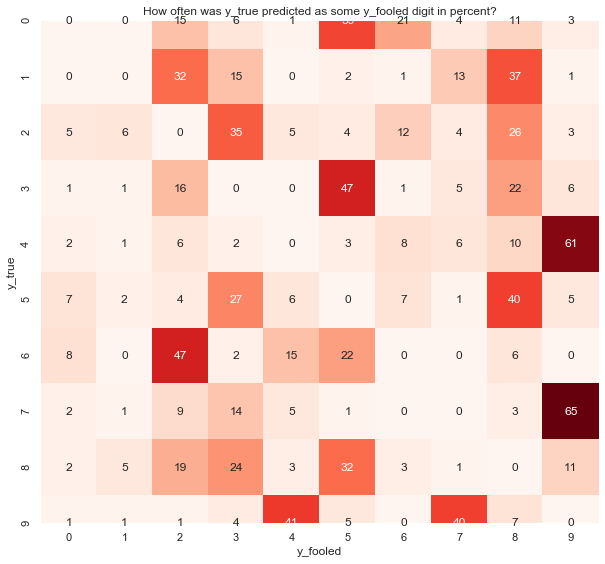

In [119]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(attacktargets, annot=True, ax=ax, cbar=False, square=True, cmap="Reds", fmt="g");
ax.set_title("How often was y_true predicted as some y_fooled digit in percent?");

## Comparison to Fast Gradient Method <a class="anchor" id="fastgradient"></a>


So far we have used gradient ascent to maximize the probability of no-matches (non-targeted & targeted) and we derived the gradient with respect to inputs for objectives that are only slightly changed in comparison to the model defining likelihood function. This way we are very close to the Fast Gradient Method given in the cleverhans library:


* Maximizing probability of no-matches:

$$ x_{p, m} = x_{m} + \delta x_{m} = x_{m} + \eta \cdot \nabla_{x_{m}} D(f_{m}|y_{m}(x_{m},w)) $$

* Fast Gradient Method:

$$ x_{p,m} = x_{m} + \delta x_{m} = x_{m} + \eta \cdot sign (\nabla_{x_{m}} J(w,x,y)) $$

Whereas $J(w,x,y)$ stands for the cost function used to train the model.  In many cases this is $E=- \log (L(t|y(x,w))$, the negative log likelihood function. One might think that this should also be the case for this example and that we could have also simply maximize the cost funtion. As this would be the same as to minimize the log-likelihood, one might think:

** ... instead of defining a discrepance function one could have also just minimize the likelihood function to yield the lowest probability of matches... **

Ohoh! Is this true? Sounds so nice, but... 

### Maximizing discrepance = minimizing likelihood?

Normally we use the likelihood to maximize the probability and we want to count those outputs $y_{n,c}$ related to target-values of $t_{n,c}=1$. Look at one example image $m$ that belongs to class 2 of 3, then for this one we would have:

$$ l = y_{1}^{0} * y_{2}^{1} * y_{3}^{0} = y_{2} $$

Hence this image contribute to the overall product over $n$ by a factor of $y_{2}$. Consequently each image $n$ would give us a y-factor of its true class whereas all the others only give us a factor of 1 such that it does not disturb our nice probability. If we would now use the same likelihood to represent the probability of no-matches we encounter a problem: To minimize the likelihood the only thing that can be done now is to set $y_{2}=0$ for image m. We would do this for all outputs that enter the likelihood by themselves. But what is with all the others? What to do with $y_{1}$ and $y_{3}$ for image m? Looking for a minimum of $y_{2}$ we could select anything for $y_{1}$ and $y_{3}$ as they just stay 1. That's ill-defined in contrast to our discrepance probability. There the situation for image m would look like this:

$$ l = y_{1}^{1} * y_{2}^{0} * y_{3}^{1} = y_{1} * y_{3} $$

And also our targeted-attack looks well for image m, if we define class 1 as our fooling class:

$$ l = y_{1}^{1} * y_{2}^{0} * y_{3}^{0} = y_{1} $$

We have made sure that only those output-values enter the likelihood that are not related to the true target and we made sure that they carry their values and not just a value of 1. 